# Conditional Autoencoder for Asset Pricing - Part 2: The Model

This notebook uses a dataset created using `yfinance` in the notebook [conditional_autoencoder_for_asset_pricing_data](05_conditional_autoencoder_for_asset_pricing_data.ipynb). The results will vary depending on which ticker downloads succeeded.

### if Colab

In [1]:
import os

if 'COLAB_GPU' in os.environ:
    print("Running on Colab")
    from google.colab import drive
    drive.mount('/content/drive')
    # Get the current working directory
    path = os.getcwd()
    # Print the path
    print("Current Path:", path)
    # 이동할 디렉토리 경로
    path = '/content/drive/MyDrive/Colab Notebooks'
    # 디렉토리 변경
    os.chdir(path)
else:
    print("Not running on Colab")

Not running on Colab


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys, os
from time import time
from pathlib import Path
from itertools import product
from tqdm import tqdm 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dot, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import quantile_transform

from scipy.stats import spearmanr

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [5]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [6]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [7]:
results_path = Path('KR_results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [8]:
characteristics = ['beta', 'betasq', 'chmom', 'dolvol', 'idiovol', 'ill', 'indmom',
                   'maxret', 'mom12m', 'mom1m', 'mom36m', 'mvel', 'retvol', 'turn', 'turn_std']

## Load Data

In [9]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: KR_results\asset_pricing\autoencoder.h5
/close                      frame        (shape->[5032,762])
/factor/beta                frame        (shape->[481458,1])
/factor/betasq              frame        (shape->[481458,1])
/factor/chmom               frame        (shape->[557031,1])
/factor/dolvol              frame        (shape->[586586,1])
/factor/idiovol             frame        (shape->[481458,1])
/factor/ill                 frame        (shape->[464593,1])
/factor/indmom              frame        (shape->[577165,1])
/factor/maxret              frame        (shape->[589355,1])
/factor/mom12m              frame        (shape->[557031,1])
/factor/mom1m               series       (shape->[592451])  
/factor/mom36m              frame        (shape->[482052,1])
/factor/mvel                frame        (shape->[595625,1])
/factor/retvol              frame        (shape->[592451,1])
/factor/turn                frame        (shape->[580790,

### Weekly returns

In [52]:
data = (pd.read_hdf(results_path / 'autoencoder.h5', 'returns')
        .stack(dropna=False)
        .to_frame('returns')
        .loc[idx['2000':, :], :])

# 램 문제 발생으로 인한 1993 -> 2013

In [53]:
with pd.HDFStore(results_path / 'autoencoder.h5') as store:
    keys = [k[1:] for k in store.keys() if k[1:].startswith('factor')]
    for key in keys:
        data[key.split('/')[-1]] = store[key].squeeze()

In [54]:
characteristics = data.drop('returns', axis=1).columns.tolist()

In [55]:
data['returns_fwd'] = data.returns.unstack('ticker').shift(-1).stack()

In [56]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 794766 entries, (Timestamp('2000-01-14 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   returns      595598 non-null  float64
 1   beta         481458 non-null  float64
 2   betasq       481458 non-null  float64
 3   chmom        557031 non-null  float64
 4   dolvol       586586 non-null  float64
 5   idiovol      481458 non-null  float64
 6   ill          464593 non-null  float64
 7   indmom       577165 non-null  float64
 8   maxret       589355 non-null  float64
 9   mom12m       557031 non-null  float64
 10  mom1m        592451 non-null  float64
 11  mom36m       482052 non-null  float64
 12  mvel         595284 non-null  float64
 13  retvol       592451 non-null  float64
 14  turn         580790 non-null  float64
 15  turn_std     589756 non-null  float64


In [57]:
nobs_by_date = data.groupby(level='date').count().max(1)
nobs_by_characteristic = pd.melt(data[characteristics].groupby(level='date').count(),
                                 value_name='# Observations',
                                 var_name=['Characteristic'])

### 주식 개수, Beta 개수

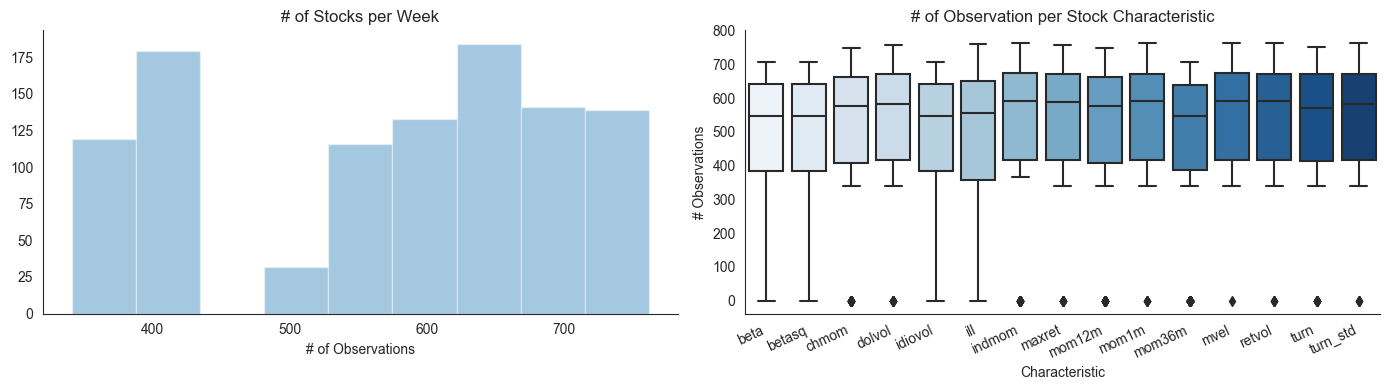

In [58]:
with sns.axes_style("white"):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
    sns.distplot(nobs_by_date, kde=False, ax=axes[0])
    axes[0].set_title('# of Stocks per Week')
    axes[0].set_xlabel('# of Observations')
    sns.boxplot(x='Characteristic',
                y='# Observations',
                data=nobs_by_characteristic,
                ax=axes[1],
                palette='Blues')
    axes[1].set_xticklabels(axes[1].get_xticklabels(),
                            rotation=25,
                            ha='right')
    axes[1].set_title('# of Observation per Stock Characteristic')
    sns.despine()
    fig.tight_layout()
    # fig.savefig(results_path / 'of Stocks per Week', dpi=600)

### Rank-normalize characteristics

In [59]:
data.loc[:, characteristics] = (data.loc[:, characteristics]
                                .groupby(level='date')
                                .apply(lambda x: pd.DataFrame(quantile_transform(x, 
                                                                                 copy=True, 
                                                                                 n_quantiles=x.shape[0]),
                                                              columns=characteristics,
                                                              index=x.index.get_level_values('ticker')))
                               .mul(2).sub(1))

In [60]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 794766 entries, (Timestamp('2000-01-14 00:00:00', freq='W-FRI'), '005930.KS') to (Timestamp('2020-01-03 00:00:00', freq='W-FRI'), '000547.KS')
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   returns      595598 non-null  float64
 1   beta         481458 non-null  float64
 2   betasq       481458 non-null  float64
 3   chmom        557031 non-null  float64
 4   dolvol       586586 non-null  float64
 5   idiovol      481458 non-null  float64
 6   ill          464593 non-null  float64
 7   indmom       577165 non-null  float64
 8   maxret       589355 non-null  float64
 9   mom12m       557031 non-null  float64
 10  mom1m        592451 non-null  float64
 11  mom36m       482052 non-null  float64
 12  mvel         595284 non-null  float64
 13  retvol       592451 non-null  float64
 14  turn         580790 non-null  float64
 15  turn_std     589756 non-null  float64


In [61]:
data.index.names

FrozenList(['date', 'ticker'])

In [62]:
data.describe()

,returns,beta,betasq,chmom,dolvol,idiovol,ill,indmom,maxret,mom12m,mom1m,mom36m,mvel,retvol,turn,turn_std,returns_fwd
count,595598.000000,4.814580e+05,481458.000000,5.570310e+05,586586.000000,4.814580e+05,464593.000000,577165.000000,589355.000000,557031.000000,5.924510e+05,482052.000000,5.952840e+05,592451.000000,580790.000000,589756.000000,595257.000000
mean,0.003292,-8.137395e-07,-0.000004,-4.759804e-07,-0.000008,-9.712880e-07,-0.000012,0.003306,-0.000002,-0.000002,-9.995265e-07,-0.000002,-4.823162e-07,-0.000009,-0.000012,-0.000016,0.003287
std,0.071555,5.784097e-01,0.578413,5.783683e-01,0.578373,5.784099e-01,0.578329,0.596680,0.578354,0.578371,5.783504e-01,0.578411,5.783544e-01,0.578366,0.578375,0.578375,0.071521
min,-0.972147,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-0.972147
25%,-0.028504,-5.008374e-01,-0.500838,-5.008237e-01,-0.500829,-5.008652e-01,-0.500765,-0.504599,-0.500789,-0.500803,-5.007657e-01,-0.500852,-5.008022e-01,-0.500849,-0.500845,-0.500850,-0.028485
50%,0.000000,-4.448633e-05,-0.000046,1.220118e-05,-0.000065,-1.771724e-05,-0.000003,0.010512,-0.000034,0.000019,0.000000e+00,-0.000140,1.471535e-05,0.000062,0.000026,-0.000003,0.000000
75%,0.028736,5.008398e-01,0.500840,5.008250e-01,0.500829,5.008613e-01,0.500764,0.480946,0.500790,0.500799,5.008169e-01,0.500830,5.007896e-01,0.500814,0.500840,0.500835,0.028721
max,2.697885,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,2.697885


In [63]:
data = data.loc[idx[:'2019', :], :]

In [64]:
data.loc[:, ['returns', 'returns_fwd']] = data.loc[:, ['returns', 'returns_fwd']].clip(lower=-1, upper=1.0)

In [65]:
data = data.fillna(-2)

In [66]:
data.to_hdf(results_path / 'autoencoder.h5', 'model_data')

## Architecture

In [67]:
data = pd.read_hdf(results_path / 'autoencoder.h5', 'model_data')

### Key parameters

In [68]:
n_factors = 3
n_characteristics = len(characteristics)
n_tickers = len(data.index.unique('ticker'))

In [69]:
n_tickers

762

In [70]:
n_characteristics

15

### Input Layer

In [71]:
input_beta = Input((n_tickers, n_characteristics), name='input_beta')
input_factor = Input((n_tickers,), name='input_factor')

### Stock Characteristics Network

In [72]:
hidden_layer = Dense(units=8, activation='relu', name='hidden_layer')(input_beta)
batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

### Factor Network

In [73]:
output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

### Output Layer

In [74]:
output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

### Compile Layer

In [75]:
model = Model(inputs=[input_beta, input_factor], outputs=output)
model.compile(loss='mse', optimizer='adam')

### Automate model generation

In [76]:
def make_model(hidden_units=8, n_factors=3):
    input_beta = Input((n_tickers, n_characteristics), name='input_beta')
    input_factor = Input((n_tickers,), name='input_factor')

    hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
    batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)
    
    output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

    output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

    output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

    model = Model(inputs=[input_beta, input_factor], outputs=output)
    model.compile(loss='mse', optimizer='adam')
    return model

### Model Summary

In [77]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_beta (InputLayer)        [(None, 762, 15)]    0           []                               
                                                                                                  
 hidden_layer (Dense)           (None, 762, 8)       128         ['input_beta[0][0]']             
                                                                                                  
 batch_norm (BatchNormalization  (None, 762, 8)      32          ['hidden_layer[0][0]']           
 )                                                                                                
                                                                                                  
 input_factor (InputLayer)      [(None, 762)]        0           []                         

### 모델 시각화

In [78]:
# model_img_file = (results_path / 'model.png' )
# tf.keras.utils.plot_model(model, to_file=model_img_file, 
#                           show_shapes=True, 
#                           show_layer_activations=True, 
#                           show_dtype=True,
#                           show_layer_names=True )

# model.save(results_path / 'model_img.h5')

## Train Model

### Cross-validation parameters

In [79]:
YEAR = 52

In [84]:
cv = MultipleTimeSeriesCV(n_splits=5, # 5
                          train_period_length=10*YEAR,
                          test_period_length=1*YEAR,
                          lookahead=1)

In [85]:
def get_train_valid_data(data, train_idx, val_idx):
    train, val = data.iloc[train_idx], data.iloc[val_idx]
    X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
    X2_train = train.loc[:, 'returns'].unstack('ticker')
    X2_val = val.loc[:, 'returns'].unstack('ticker')
    y_train = train.returns_fwd.unstack('ticker')
    y_val = val.returns_fwd.unstack('ticker')
    return X1_train, X2_train, y_train, X1_val, X2_val, y_val

### Hyperparameter Options

In [86]:
factor_opts = [2, 3, 4, 5, 6] # 2, 3, 4, 5, 6
unit_opts = [8, 16, 32] # 8, 16, 32

In [87]:
param_grid = list(product(unit_opts, factor_opts))

### Run Cross-Validation

In [88]:
batch_size = 32

In [89]:
cols = ['units', 'n_factors', 'fold', 'epoch', 'ic_mean', 
        'ic_daily_mean', 'ic_daily_std', 'ic_daily_median']

In [90]:
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback
from keras.utils import Sequence

# Define a custom data generator to feed data to the model
class DataGenerator(Sequence):
    def __init__(self, X1, X2, y, batch_size):
        self.X1 = X1
        self.X2 = X2
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X1) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_X1 = self.X1[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X2 = self.X2[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return [batch_X1, batch_X2], batch_y

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

In [91]:
start = time()
for units, n_factors in param_grid:
    print("units:", units, ", n_factors:", n_factors)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        train_gen = DataGenerator(X1_train, X2_train, y_train, batch_size=batch_size)
        val_gen = DataGenerator(X1_val, X2_val, y_val, batch_size=batch_size)
        model = make_model(hidden_units=units, n_factors=n_factors)
        for epoch in range(250):
            model.fit_generator(train_gen,
                                validation_data=val_gen,
                                epochs=epoch + 1,
                                initial_epoch=epoch, verbose=False, shuffle=True, callbacks=ClearMemory())
            y_pred = model.predict_generator(val_gen, callbacks=ClearMemory())
            y_true = y_val.stack().values
            date_index = y_val.stack().index
            result = (pd.DataFrame({'y_pred': y_pred.reshape(-1),
                                    'y_true': y_true},
                                   index=date_index)
                      .replace(-2, np.nan).dropna())
            r0 = spearmanr(result.y_true, result.y_pred)[0]
            r1 = result.groupby(level='date').apply(lambda x: spearmanr(x.y_pred,
                                                                        x.y_true)[0])

            scores.append([units, n_factors, fold, epoch, r0,
                           r1.mean(), r1.std(), r1.median()])
            if epoch % 50 == 0:
                print(f'{format_time(time()-start)} | {n_factors} | {units:02} | {fold:02}-{epoch:03} | {r0:6.2%} | '
                  f'{r1.mean():6.2%} | {r1.median():6.2%}')
            
        scores = pd.DataFrame(scores, columns=cols)
        scores.to_hdf(results_path / 'scores.h5', f'{units}/{n_factors}')

units: 8 , n_factors: 2
00:00:02 | 2 | 08 | 00-000 | -4.05% | -4.42% | -1.47%
00:00:27 | 2 | 08 | 00-050 | -2.38% | -3.92% | -2.41%
00:00:52 | 2 | 08 | 00-100 | -2.23% | -3.75% | -1.28%
00:01:18 | 2 | 08 | 00-150 | -2.61% | -3.10% | -1.47%
00:01:43 | 2 | 08 | 00-200 | -4.43% | -1.99% |  0.08%
00:02:13 | 2 | 08 | 01-000 |  2.36% |  2.37% |  2.07%
00:02:43 | 2 | 08 | 01-050 | -0.41% |  0.47% |  1.27%
00:03:14 | 2 | 08 | 01-100 | -0.43% |  0.35% |  0.28%
00:03:42 | 2 | 08 | 01-150 | -0.44% |  1.06% |  1.12%
00:04:10 | 2 | 08 | 01-200 | -0.31% |  1.68% |  0.06%
00:04:39 | 2 | 08 | 02-000 | -2.53% | -3.54% | -5.19%
00:05:07 | 2 | 08 | 02-050 | -1.39% | -1.57% | -1.27%
00:05:35 | 2 | 08 | 02-100 | -1.68% | -1.03% | -0.70%
00:06:02 | 2 | 08 | 02-150 | -2.18% | -0.89% | -0.04%
00:06:29 | 2 | 08 | 02-200 | -2.61% | -0.87% |  0.40%
00:06:57 | 2 | 08 | 03-000 | -0.82% | -2.10% | -1.72%
00:07:24 | 2 | 08 | 03-050 | -1.14% | -0.81% |  0.25%
00:07:52 | 2 | 08 | 03-100 | -0.62% | -0.08% |  0.06%
00:0

### Evaluate Results

In [92]:
scores = []
with pd.HDFStore(results_path / 'scores.h5') as store:
    for key in store.keys():
        scores.append(store[key])
print(scores)
scores = pd.concat(scores)

[     units  n_factors  fold  epoch   ic_mean  ic_daily_mean  ic_daily_std  \
0        8          2     0      0 -0.040467      -0.044185      0.157133   
1        8          2     0      1 -0.040034      -0.046525      0.157454   
2        8          2     0      2 -0.039022      -0.047462      0.157251   
3        8          2     0      3 -0.038553      -0.048246      0.157361   
4        8          2     0      4 -0.038434      -0.049712      0.157408   
..     ...        ...   ...    ...       ...            ...           ...   
245      8          2     0    245 -0.060154      -0.028111      0.114439   
246      8          2     0    246 -0.061711      -0.028357      0.114208   
247      8          2     0    247 -0.058859      -0.023290      0.108154   
248      8          2     0    248 -0.057346      -0.017558      0.100698   
249      8          2     0    249 -0.050417      -0.015545      0.099857   

     ic_daily_median  
0          -0.014684  
1          -0.027027  
2    

In [93]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3750 entries, 0 to 249
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   units            3750 non-null   int64  
 1   n_factors        3750 non-null   int64  
 2   fold             3750 non-null   int64  
 3   epoch            3750 non-null   int64  
 4   ic_mean          3750 non-null   float64
 5   ic_daily_mean    3750 non-null   float64
 6   ic_daily_std     3750 non-null   float64
 7   ic_daily_median  3750 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 263.7 KB


In [94]:
avg = (scores.groupby(['n_factors', 'units', 'epoch'])
       ['ic_mean', 'ic_daily_mean', 'ic_daily_median']
       .mean()
      .reset_index())

In [95]:
avg.nlargest(n=20, columns=['ic_daily_median'])

,n_factors,units,epoch,ic_mean,ic_daily_mean,ic_daily_median
3001,6,8,1,0.049023,0.054658,0.061283
3000,6,8,0,0.044577,0.051750,0.059643
3002,6,8,2,0.044427,0.051191,0.054749
2883,5,32,133,0.016092,0.044448,0.052153
3003,6,8,3,0.041965,0.051911,0.051215
2858,5,32,108,0.016261,0.037543,0.050634
2859,5,32,109,0.016382,0.037988,0.050587
2835,5,32,85,0.024101,0.039988,0.050546
2862,5,32,112,0.015454,0.038013,0.050502
2857,5,32,107,0.016340,0.037044,0.050277


In [96]:
top = (avg.groupby(['n_factors', 'units'])
       .apply(lambda x: x.nlargest(n=5, columns=['ic_daily_median']))
       .reset_index(-1, drop=True))

top.nlargest(n=5, columns=['ic_daily_median'])

n_factors  units  epoch   ic_mean  ic_daily_mean  \
n_factors units                                                     
6         8              6      8      1  0.049023       0.054658   
          8              6      8      0  0.044577       0.051750   
          8              6      8      2  0.044427       0.051191   
5         32             5     32    133  0.016092       0.044448   
6         8              6      8      3  0.041965       0.051911   

                 ic_daily_median  
n_factors units                   
6         8             0.061283  
          8             0.059643  
          8             0.054749  
5         32            0.052153  
6         8             0.051215

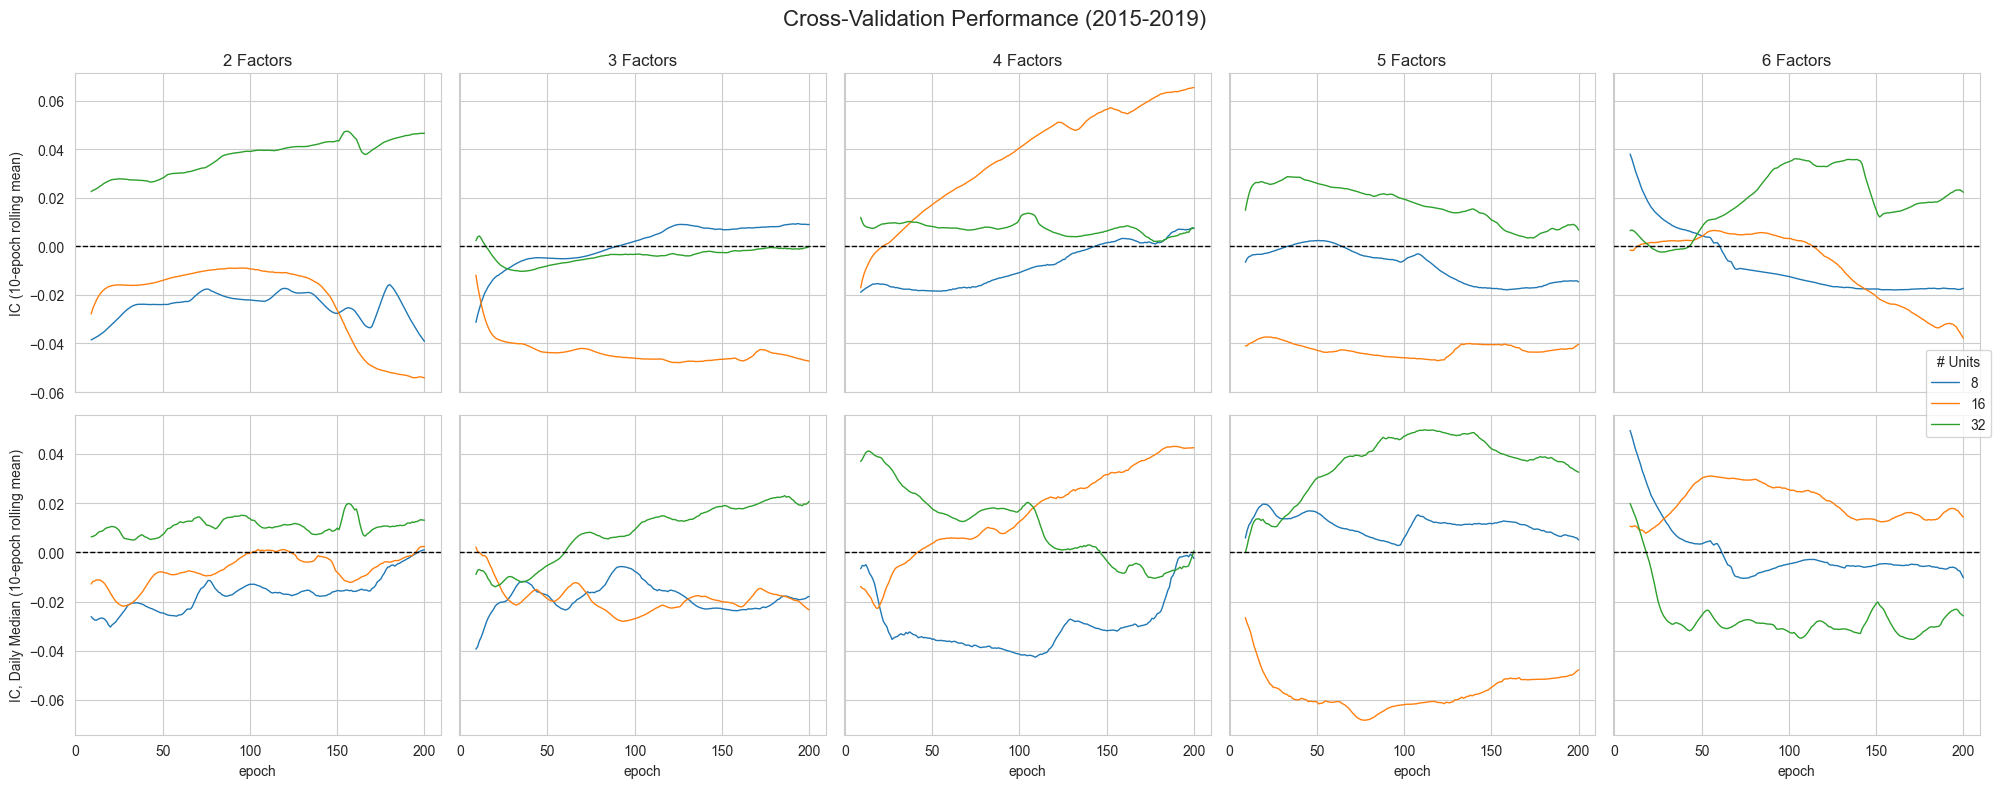

In [97]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8), sharey='row', sharex=True)

for n in range(2, 7):
    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_mean')
    df.rolling(10).mean().loc[:200].plot(ax=axes[0][n-2], lw=1, title=f'{n} Factors')
    axes[0][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[0][n-2].get_legend().remove()
    axes[0][n-2].set_ylabel('IC (10-epoch rolling mean)')

    df = avg[avg.n_factors==n].pivot(index='epoch', columns='units', values='ic_daily_median')
    df.rolling(10).mean().loc[:200].plot(ax=axes[1][n-2], lw=1)
    axes[1][n-2].axhline(0, ls='--', c='k', lw=1)
    axes[1][n-2].get_legend().remove()
    axes[1][n-2].set_ylabel('IC, Daily Median (10-epoch rolling mean)')

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title='# Units')
fig.suptitle('Cross-Validation Performance (2015-2019)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'cv_performance', dpi=600);

## Generate Predictions

We'll average over a range of epochs that appears to deliver good predictions.

In [100]:
n_factors = 4
units = 16
batch_size = 32
first_epoch = 160
last_epoch = 190

In [101]:
predictions = []
for epoch in tqdm(list(range(first_epoch, last_epoch))):
    epoch_preds = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(data)):
        X1_train, X2_train, y_train, X1_val, X2_val, y_val = get_train_valid_data(data,
                                                                                  train_idx,
                                                                                  val_idx)
        
        train_gen = DataGenerator(X1_train, X2_train, y_train, batch_size=batch_size)
        val_gen = DataGenerator(X1_val, X2_val, y_val, batch_size=batch_size)
        
        model.fit_generator(train_gen,
                    validation_data=val_gen,
                  epochs=epoch,
                  verbose=False,
                  shuffle=True, callbacks=ClearMemory())
        epoch_preds.append(pd.Series(model.predict_generator(val_gen, callbacks=ClearMemory()).reshape(-1),
                                     index=y_val.stack().index).to_frame(epoch))

    predictions.append(pd.concat(epoch_preds))

  0%|          | 0/30 [00:00<?, ?it/s]

In [58]:
predictions_combined = pd.concat(predictions, axis=1).sort_index()   

In [59]:
predictions_combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 994500 entries, (Timestamp('2015-01-09 00:00:00'), 'A') to (Timestamp('2019-12-27 00:00:00'), 'ZYXI')
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   50      994500 non-null  float32
 1   51      994500 non-null  float32
 2   52      994500 non-null  float32
 3   53      994500 non-null  float32
 4   54      994500 non-null  float32
 5   55      994500 non-null  float32
 6   56      994500 non-null  float32
 7   57      994500 non-null  float32
 8   58      994500 non-null  float32
 9   59      994500 non-null  float32
 10  60      994500 non-null  float32
 11  61      994500 non-null  float32
 12  62      994500 non-null  float32
 13  63      994500 non-null  float32
 14  64      994500 non-null  float32
 15  65      994500 non-null  float32
 16  66      994500 non-null  float32
 17  67      994500 non-null  float32
 18  68      994500 non-null  float32
 19  69      9945

In [60]:
predictions_combined.to_hdf(results_path / 'predictions.h5', 'predictions')

In [61]:
predictions_combined

50        51        52        53        54        55  \
date       ticker                                                               
2015-01-09 A       0.163845  2.253947  0.127273  0.331235  0.368946  0.274428   
           AA      0.118959 -1.111887  0.648148  0.384320  0.117708  0.151717   
           AADI   -1.328732 -1.842666 -0.962857 -1.377674 -1.194699 -1.531664   
           AAIC    0.297681  2.981762  0.089403  0.381781  0.412266  0.298492   
           AAL    -0.659490 -2.965192  0.424770  0.254553  0.270742  0.256534   
...                     ...       ...       ...       ...       ...       ...   
2019-12-27 ZUO    -0.126787 -0.009605  0.001154  0.025288  0.036062  0.020983   
           ZVRA   -0.485836 -0.268491 -0.027064  0.027107  0.043426  0.011752   
           ZWS    -0.015085 -0.023858  0.017088  0.035486  0.035245  0.010735   
           ZYME   -0.130669  0.053675  0.027365  0.033928  0.031878  0.014364   
           ZYXI    0.106575  0.044895  0.023050  0.030492  0.035902  0.009103   

                         56        57        58        59  ...        70  \
date       ticker                                          ...             
2015-01-09 A       0.278209  0.280361  0.293108  0.332145  ...  0.317030   
           AA      0.269880  0.281045  0.341255  0.336829  ...  0.322095   
           AADI   -1.492771 -1.286886 -1.405183 -1.301660  ... -1.559719   
           AAIC    0.275337  0.275040  0.279732  0.333327  ...  0.321817   
           AAL     0.300733  0.300509  0.340131  0.332326  ...  0.316456   
...                     ...       ...       ...       ...  ...       ...   
2019-12-27 ZUO     0.028174  0.024564  0.015017  0.017405  ... -0.003368   
           ZVRA    0.021900  0.025650  0.024678  0.024838  ... -0.002937   
           ZWS     0.020892  0.020042  0.014949  0.018891  ... -0.002961   
           ZYME    0.019338  0.013764  0.011871  0.016113  ... -0.002940   
           ZYXI    0.019475  0.018767  0.016591  0.020396  ... -0.003608   

                         71        72        73        74        75        76  \
date       ticker                                                               
2015-01-09 A       0.339076  0.322740  0.326238  0.550870  0.299175  0.348998   
           AA      0.323567  0.322120  0.298718  0.626114  0.303172  0.393962   
           AADI   -1.209913 -1.507776 -1.488106 -1.898374 -1.458233 -1.565765   
           AAIC    0.325378  0.319755  0.307327  0.453940  0.303913  0.348626   
           AAL     0.332708  0.318068  0.329193  0.608879  0.315767  0.372209   
...                     ...       ...       ...       ...       ...       ...   
2019-12-27 ZUO     0.007164  0.009423  0.006905  0.007982  0.008723  0.006857   
           ZVRA    0.009489  0.010290  0.007870  0.008098  0.008320  0.007220   
           ZWS     0.007963  0.009845  0.007388  0.008004  0.008567  0.007078   
           ZYME    0.007529  0.009540  0.007114  0.007890  0.008619  0.006868   
           ZYXI    0.007362  0.009630  0.007043  0.008035  0.008694  0.006999   

                         77        78        79  
date       ticker                                
2015-01-09 A       0.324916  0.282634  0.308473  
           AA      0.293908  0.259345  0.290426  
           AADI   -1.389038 -1.298695 -1.396177  
           AAIC    0.307179  0.279705  0.304476  
           AAL     0.306310  0.275149  0.296512  
...                     ...       ...       ...  
2019-12-27 ZUO     0.009580  0.006314  0.012547  
           ZVRA    0.011311  0.007730  0.012445  
           ZWS     0.010279  0.007313  0.012656  
           ZYME    0.009687  0.006690  0.012711  
           ZYXI    0.010037  0.006613  0.012590  

[994500 rows x 30 columns]